# Composing & Modeling Parallel Sorting Performance Data
## Part B: Modeling Parallel Sorting Data

In part B, we use machine learning to predict the parallel algorithm class from the performance data we processed and composed in part A.

## 1. Import Necessary Packages

Import packages:
- `numpy` and `pandas` for help with data operations.
- `sklearn` for modeling.
- `matplotlib` to plot our model's performance statistics.
- `thicket` to unpickle the Thicket from part A.
- `tqdm` for modeling progress bars.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics, svm
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

import thicket as th

## 2. Define Modeling Helper Functions
- `prep_data` performs standardization scaling on the numerical columns and converts categorical columns to the correct format for modeling.
- `split_X_y` splits a dataset into input data and labels.
- `compute_model_metrics` computes model statistics given the true labels, predicted labels, and probabilities.

In [2]:
def prep_data(
    data,
    numerical_columns,
    categorical_columns,
    scaling=False,
):

    def configure_categorical(model_data, categories):
        for col in categories:
            # Encode any "string" categorical variables
            if model_data[col].dtype == "object":
                # Strings to ints
                model_data.loc[:, [col]] = LabelEncoder().fit_transform(model_data[col])
            else:
                # anything else to int
                model_data[col] = model_data[col].astype(int)
                model_data.loc[:, [col]] = model_data[col]
            # Set to categorical
            model_data.loc[:, [col]] = model_data[col].astype("category")

        return model_data

    # preprocessing
    if scaling:
        scaler = StandardScaler().set_output(transform="pandas")
        data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

    if len(categorical_columns) > 0:
        data = configure_categorical(data, categorical_columns)

    return data

def split_X_y(data):
    y = pd.get_dummies(data["Algorithm"], dtype=np.float64)
    y_index = y.index
    y_values = y.values.argmax(axis=1)
    y = pd.Series(y_values, index=y_index)
    X = data.drop(columns=["Algorithm"])
    return X, y

def compute_model_metrics(y_true, y_pred, y_proba):

    def ravel(tlist, max_num):
        tarr = []
        for y in tlist:
            t1 = np.zeros(max_num + 1)
            t1[y] = 1
            tarr += t1.tolist()
        return tarr

    def unravel_true_pred(y_true, y_pred):
        max_num = max(max(y_pred), max(y_true))
        unravel_true = ravel(y_true, max_num)
        unravel_pred = ravel(y_pred, max_num)
        return unravel_true, unravel_pred

    acc = metrics.accuracy_score(y_true=y_true, y_pred=y_pred)  # Accuracy
    pre = metrics.precision_score(
        y_true=y_true, y_pred=y_pred, average="weighted", zero_division=0
    )  # Precision
    rec = metrics.recall_score(
        y_true=y_true, y_pred=y_pred, average="weighted", zero_division=0
    )  # Recall
    f1 = metrics.f1_score(
        y_true=y_true, y_pred=y_pred, average="weighted", zero_division=0
    )  # F1
    conf_matrix = metrics.confusion_matrix(
        y_true=y_true, y_pred=y_pred
    )  # Confusion matrix
    unravel_true, unravel_pred = unravel_true_pred(y_true, y_pred)
    y_proba = y_proba.ravel()
    try:  # case where class sample didnt get into data
        roc_auc_score = metrics.roc_auc_score(
            y_true=unravel_true,
            y_score=y_proba,
            multi_class="ovr",
            average="weighted",
        )
    except ValueError:
        roc_auc_score = 0
    return acc, pre, rec, f1, conf_matrix, roc_auc_score

## 3. Modeling Preparation

### 3A. Unpickle the Thicket from part A

In [3]:
tk = th.Thicket.from_pickle("thicket-modeldata.pkl")

### 3B. Concatenate Features
To match the expected format of the Scikit-learn models we will use, concatenate the features together such that each row in the `model_data` DataFrame is a data sample (profile). We can achieve this desired format by using `pd.DataFrame.unstack()` to unstack the node index, and using `pd.concat()` to concatenate the results.

In [4]:
model_data = pd.concat(
    [
        tk.dataframe.loc[tk.perf_idx].unstack(level="node"),
        tk.dataframe.loc[tk.presence_idx].unstack(level="node"),
        tk.metadata["Algorithm"]
    ],
    axis="columns"
)

### 3C. Define Categorical and Numerical Columns

In [5]:
categorical_columns = [
    ("Node presence", tk.get_node("comp_small")),
    ("Node presence", tk.get_node("comm_small"))
]
numerical_columns = list(set(model_data.columns) - set(categorical_columns + ["Algorithm"]))

### 3D. Define Dictionary of Classifiers

In [6]:
classifiers = {
    "DecisionTree": DecisionTreeClassifier(
            class_weight="balanced",
        ),
    "RandomForest": RandomForestClassifier(
            class_weight="balanced",
        ),
    "SVM": svm.SVC(
            kernel="rbf",
            probability=True,
        )
}

## 4. Model Training Loop
For each model we run for multiple trials where:
    - We use `prep_data` which can be configured differently for different models.
    - We use `KFold` cross validation to ensure we are testing the entire dataset.
        - Initialize a new model and fit it to the training data set.
        - Compute the model statistics and store them in a dataframe with any other model metadata.

We concatenate all of the model result information into `model_results`, which we will use to plot the model performance.

In [7]:
model_results = pd.DataFrame()
folds = 10
trials = 1
for model_name in classifiers.keys():
    pbar = tqdm(range(trials))
    for t in pbar:
        metadata_list = []
        mdc = model_data.copy()
        mdc = prep_data(
            data=mdc,
            numerical_columns=numerical_columns,
            categorical_columns=categorical_columns,
            scaling=True,
        )
        kf = KFold(
            n_splits=folds, 
            random_state=None,
            )
        for fold, (train_indices, test_indices) in enumerate(kf.split(mdc)):
            pbar.set_description(f"{model_name}: Trial {t+1}/{trials}, Fold {fold+1}/{folds}")
            
            train_data = mdc.iloc[train_indices]
            test_data = mdc.iloc[test_indices]
            
            X_train, y_train = split_X_y(train_data)
            X_test, y_test = split_X_y(test_data)

            # Init
            model = classifiers[model_name]
            
            # Train
            model.fold = fold
            model.fit(X_train, y_train)

            # Compute scores
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test.astype(np.float32))
            acc, pre, rec, f1, conf_matrix, roc_auc_score = compute_model_metrics(
                y_true=y_test, y_pred=y_pred, y_proba=y_proba
            )

            y_proba = [tuple(i for i in j) for j in y_proba]
            profile_labels = [mdc.index[i] for i in test_indices]
            assert len(profile_labels) == len(test_indices)

            values_dict = {
                # Profile labels
                "profile": profile_labels,
                # Model preds
                "y_pred": y_pred.tolist(),
                "y_proba": y_proba,
                "y_true": y_test.tolist(),
                # Model Performance data
                "classifier": model_name,
                "trial": t+1,
                "test_acc": acc,
                "test_pre": pre,
                "test_rec": rec,
                "test_f1": f1,
                "test_roc_auc": roc_auc_score,
                "trials": trials,
                "fold": fold,
                "n_fold": folds,
                "num_files": len(tk.profile),
            }

            tdf = pd.DataFrame.from_dict(values_dict)
            metadata_list.append(tdf)
        df = pd.concat(metadata_list)
        model_results = pd.concat([model_results, df])

SVM: Trial 1/1, Fold 10/10: 100%|██████████| 1/1 [00:38<00:00, 38.47s/it]


## 5. Visualize Model Performance
With the `_plot_bars()` function, we can visualize the per-fold accuracy of each classifier for each model performance statistic. We notice that although performance varies slightly across folds, the tree models perform the best on performance data.

In [8]:
def _plot_bars(
        mean_df, 
        std_df,  
        grouper, 
        x_group, 
        xlabel=None, 
        ylabel=None, 
        title=None, 
        font=None,
        legend_dict=None,
        legend=None,
        color=None,
        random=False,
        ylim=(0, 1),
        colorbar=None,
        kind="bar",
    ):
    unstacker = list(set(grouper) - set([x_group]))
    mu_df = mean_df.unstack(level=unstacker)
    su_df = std_df.unstack(level=unstacker)

    if font:
        plt.rcParams.update(font)

    for col in mu_df.columns.get_level_values(0).unique():
        tdf1 = mu_df[col]
        if col == "test_acc" and random:
            tdf1["Random Classifier"] = [1/num_classes for num_classes in tdf1.index.get_level_values(0)]
        ax = tdf1.plot(kind=kind, yerr=su_df[col], capsize=5, figsize=(10, 5), color=color, legend=legend)
        plt.ylim(ylim)
        if xlabel:
            plt.xlabel(xlabel)
        if ylabel:
            plt.ylabel(ylabel)
        if title:
            plt.title(title)
        plt.grid(False)
        if legend_dict and legend:
            plt.legend(
                **legend_dict
            )
        if colorbar is not None:
            plt.colorbar(colorbar, label='Parameter', ax=ax)
        plt.xticks(rotation=90)
        plt.show()

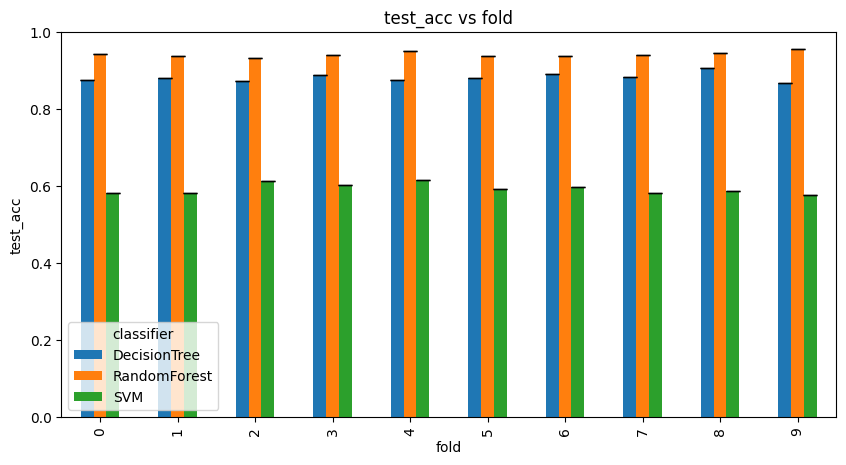

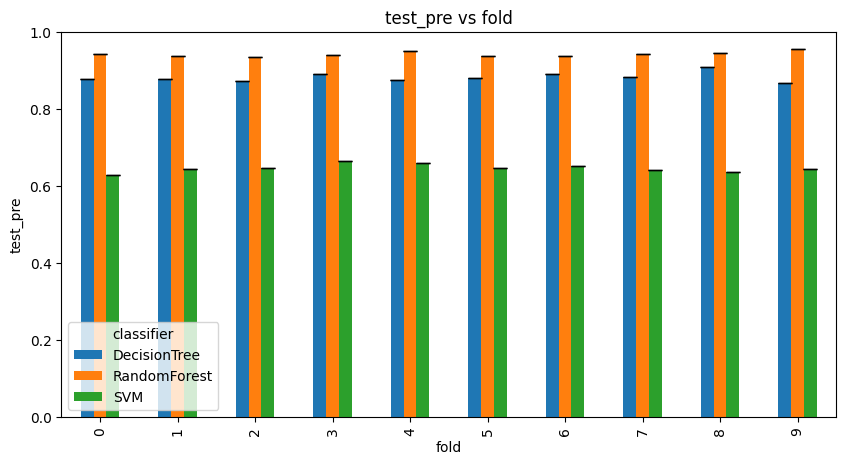

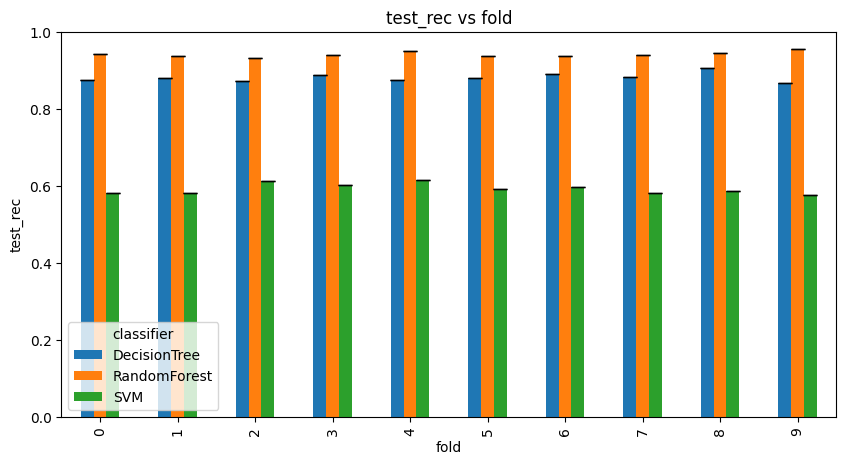

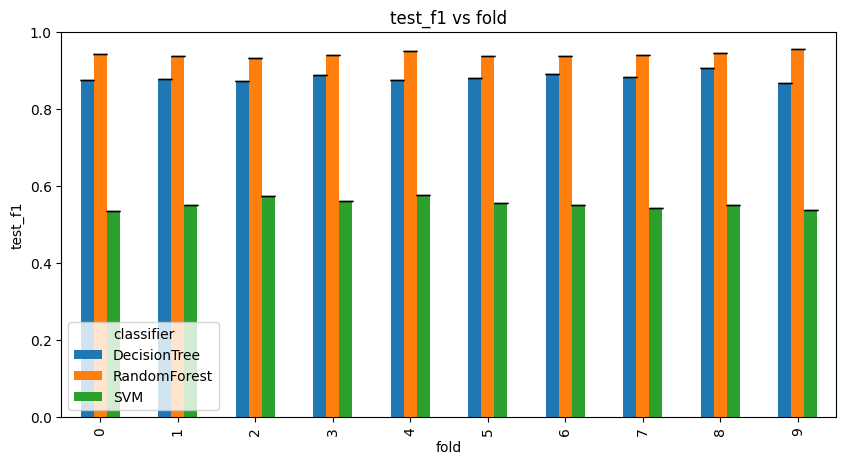

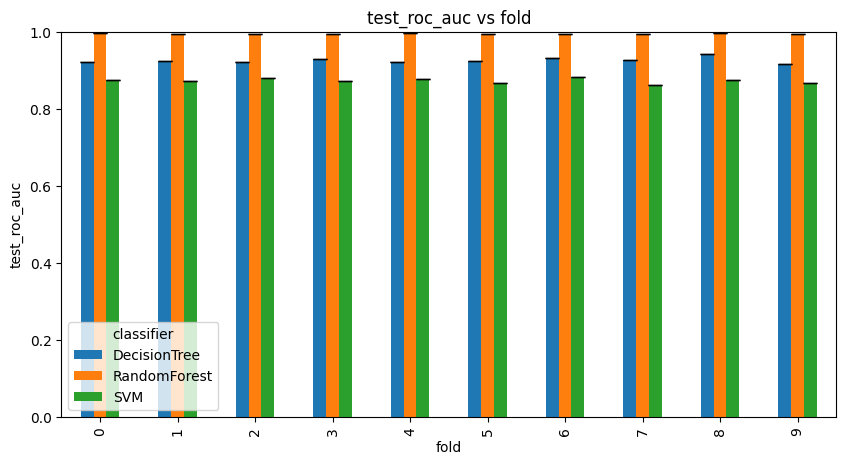

In [9]:
# We can optionally join information from the Thicket metadata table to use in analysis of model performance.
model_results = model_results.join(tk.metadata[["Algorithm", "InputSize", "InputType", "num_procs", "group_num", "Datatype"]], on="profile")

for met in ["test_acc", "test_pre", "test_rec", "test_f1", "test_roc_auc"]:
    config = [
        "fold",
        "classifier",
    ]
    mean_df = model_results[[met]+config].groupby(config).mean()
    std_df = model_results[[met]+config].groupby(config).std()
    _plot_bars(
        mean_df=mean_df, 
        std_df=std_df, 
        grouper=config, 
        x_group="fold",
        ylabel=met,
        xlabel="fold",
        legend=True,
        title=f"{met} vs fold",
    )